In [1]:
from framework.simulation import FaradayThinSource,FaradayThickSource
from framework.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from framework.io import Reader, Writer
from framework.base import Dataset
from framework.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction import OFunction
from framework.utils import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction import TSV, TV, L1, Chi2
from framework.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils import Gaussian
from framework.dictionaries.discrete import DiscreteWavelet
from framework.dictionaries.undecimated import UndecimatedWavelet
from framework.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools

In [2]:
def chi2_calc(residuals):
    if residuals.dtype == np.complex64 or residuals.dtype == np.complex128:
        data = (residuals.real * residuals.real) + (residuals.imag * residuals.imag)
    else:
        data = residuals**2
    return np.sum(data)

In [3]:
def aicbic(residuals_coeffs, x_coeffs):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
    else:     
        df = np.count_nonzero(x)
    l = len(residuals)
    return l*np.log(rss/l) + 2*df, l*np.log(rss/l) + df*np.log(l)

In [4]:
np.random.seed(666)

In [5]:
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)

In [6]:
peak_thinsource = 0.0035
peak_thicksource = 0.0035

In [7]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=1.0)

In [8]:
thicksource = FaradayThickSource(nu=nu, s_nu=peak_thicksource, phi_fg=140, phi_center=200, spectral_idx=1.0)

In [9]:
thinsource.simulate()
thicksource.simulate()

In [10]:
measurements = thinsource + thicksource

In [11]:
measurements.remove_channels(0.3, chunksize=100)

In [12]:
measurements.apply_noise(peak_thinsource*0.4)

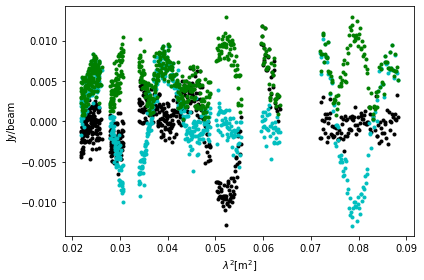

In [13]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [14]:
parameter = Parameter()

In [15]:
parameter.calculate_cellsize(dataset=measurements)

FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 18209.648


In [16]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [17]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [18]:
F_dirty = dft.backward(measurements.data)

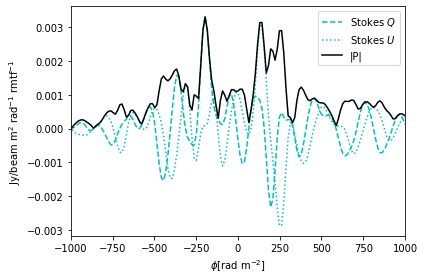

In [19]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [20]:
idx_noise = np.where(np.abs(parameter.phi)>8000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
noise_F

4.990068e-05

In [21]:
P_back = nufft.forward_normalized(F_dirty)

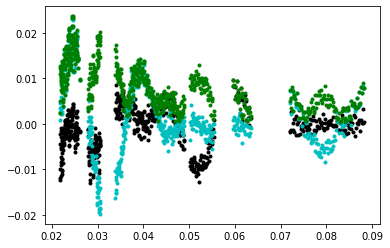

In [22]:
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [23]:
F_back = nufft.backward(measurements.data)

(-1000.0, 1000.0)

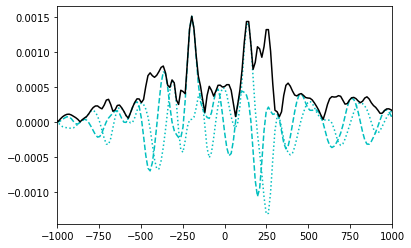

In [24]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

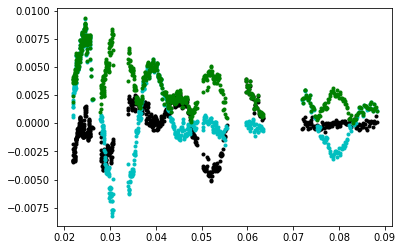

In [25]:
P_back = nufft.forward_normalized(F_back)
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [26]:
#wav = DiscreteWavelet(wavelet_name="db4", mode="periodization")
wav = UndecimatedWavelet(wavelet_name="coif1")

In [27]:
lambda_l1 = np.sqrt(2 * len(measurements.data) + 4 * np.sqrt(len(measurements.data))) * noise_F * np.sqrt(0.5)
#lambda_l1 = np.sqrt(len(measurements.data)) * noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [28]:
len(F_back)

2784

In [29]:
len(parameter.data)

2784

In [30]:
parameter.data = F_dirty

In [31]:
parameter.complex_data_to_real()

In [32]:
wav.calculate_max_level(parameter.data)

6

In [33]:
parameter.data = wav.decompose(parameter.data)

In [34]:
parameter.n

38976

In [35]:
nufft.parameter.n

2784

In [36]:
parameter.n

38976

In [37]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 27
Iteration:  0  objective function value: 0.00836


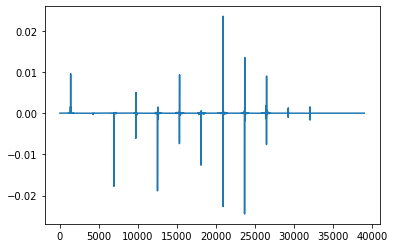

In [38]:
# Coefficients
plt.plot(X.data)

In [39]:
print(X.calculate_sparsity())

99.99743431855501


In [40]:
X.data = wav.reconstruct(X.data)

(-1000.0, 1000.0)

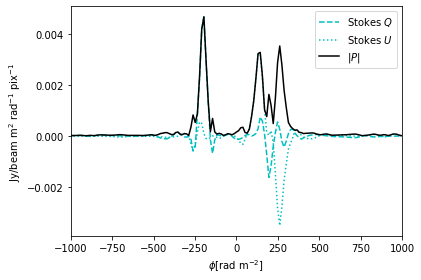

In [41]:
X.real_data_to_complex()

plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

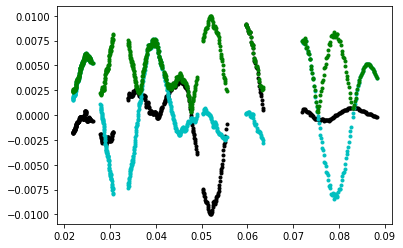

In [42]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

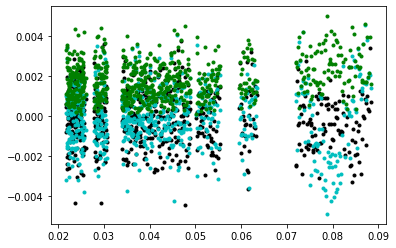

In [43]:
plt.plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")

(-1000.0, 1000.0)

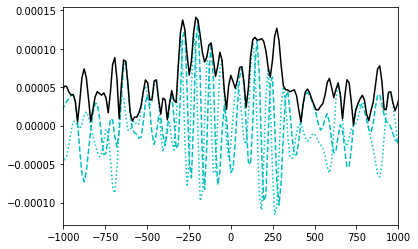

In [44]:
F_residual = nufft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [45]:
lags, autocorr_res, autocorr_res_sq, bound, percentage_real_in, percentage_imag_in, percentage_real_in_sq, percentage_imag_in_sq = measurements.assess_residuals()

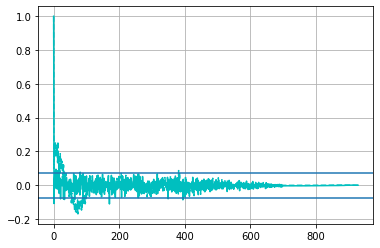

In [46]:
plt.plot(lags, autocorr_res.real, 'c-', label=r"Real part")
plt.plot(lags, autocorr_res.imag, 'c--', label=r"Imaginary part")
plt.axhline(-bound)
plt.axhline(bound)
plt.grid()

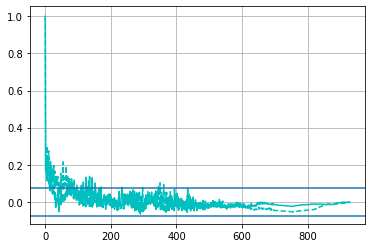

In [47]:
plt.plot(lags, autocorr_res_sq.real, 'c-', label=r"Real part")
plt.plot(lags, autocorr_res_sq.imag, 'c--', label=r"Imaginary part")
plt.axhline(-bound)
plt.axhline(bound)
plt.grid()

In [48]:
percentage_real_in, percentage_imag_in

(98.38536060279871, 92.35737351991389)

In [49]:
percentage_real_in_sq, percentage_imag_in_sq

(95.15608180839612, 91.28094725511302)

In [50]:
"""
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
arr_real = pacf(x=measurements.residual.real, nlags=len(measurements.residual.real)//2 - 1, method="ols-adjusted")
arr_imag = pacf(x=measurements.residual.imag, nlags=len(measurements.residual.imag)//2 - 1, method="ols-adjusted")
plt.plot(arr_real, '.')
plt.plot(arr_imag, '.')
plt.axhline(-bound)
plt.axhline(bound)
plt.grid()
"""

'\nfrom statsmodels.tsa.stattools import pacf\nfrom statsmodels.graphics.tsaplots import plot_pacf\narr_real = pacf(x=measurements.residual.real, nlags=len(measurements.residual.real)//2 - 1, method="ols-adjusted")\narr_imag = pacf(x=measurements.residual.imag, nlags=len(measurements.residual.imag)//2 - 1, method="ols-adjusted")\nplt.plot(arr_real, \'.\')\nplt.plot(arr_imag, \'.\')\nplt.axhline(-bound)\nplt.axhline(bound)\nplt.grid()\n'

In [51]:
conv_model = X.convolve(normalized=True) + F_residual

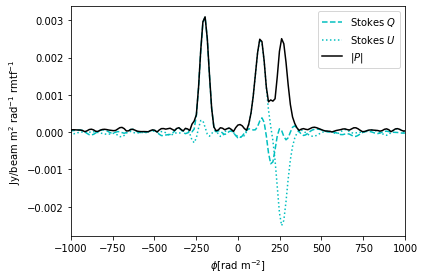

In [52]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("restored.png", dpi=100)

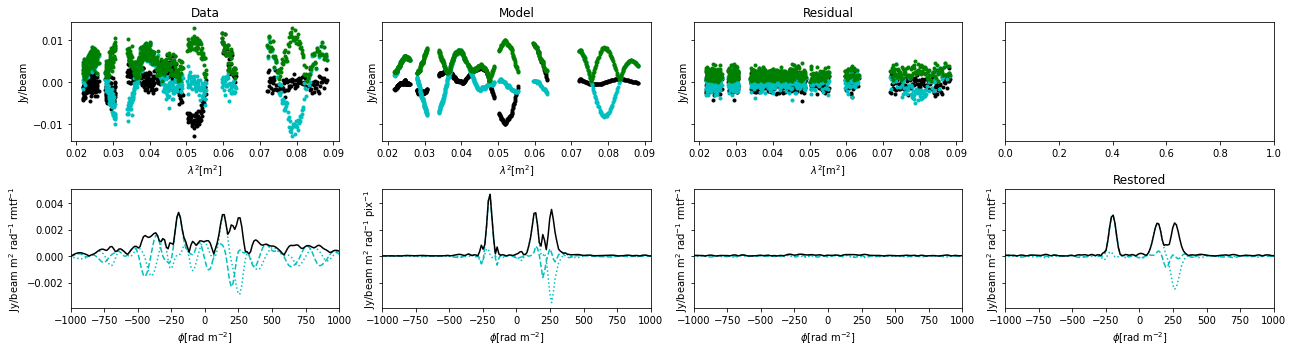

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))

# Data
ax[0,0].plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
ax[0,0].plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
ax[0,0].plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
ax[0,0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,0].set_ylabel(r'Jy/beam')
ax[0,0].title.set_text("Data")

ax[1,0].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[1,0].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[1,0].plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
ax[1,0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,0].set_xlim([-1000,1000])

# Model
ax[0,1].plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
ax[0,1].plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
ax[0,1].plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
ax[0,1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,1].set_ylabel(r'Jy/beam')
ax[0,1].title.set_text("Model")

ax[1,1].plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
ax[1,1].plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
ax[1,1].plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
ax[1,1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1,1].set_xlim([-1000,1000])

# Residual

# Model
ax[0,2].plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
ax[0,2].plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
ax[0,2].plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")
ax[0,2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,2].set_ylabel(r'Jy/beam')
ax[0,2].title.set_text("Residual")

ax[1,2].plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
ax[1,2].plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
ax[1,2].plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
ax[1,2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,2].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,2].set_xlim([-1000,1000])
fig.tight_layout()

ax[1,3].plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
ax[1,3].plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
ax[1,3].plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
ax[1,3].set_xlim([-1000,1000])
ax[1,3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,3].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,3].title.set_text("Restored")